In [170]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize
%matplotlib inline
from glob import glob
from astropy.constants import c
from scipy.fftpack import fft, fftfreq
c = c.value*1e-6 #Speed of light in mm/ns
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit
import matplotlib.mlab as mlab
import scipy.optimize as op
#import emcee
#import corner
#import h5py

In [171]:
hdf5_name = '15-02-4/150/X/'
save_name = '15-02-4_150_X_'
datadir = '/Users/daichitsuna/Documents/intern/mesh_filters/MeshFilters/data/15-02-4 150GHz Xpol/'
files = glob(datadir + '*.txt') 
no_sample_one_arm_scans = [0,1,2]# [0,1,2]
sample_one_arm_scans = [3,4,5]# [0,1,2]
no_sample_scans = range(6, len(files),2)
sample_scans = range(7, len(files),2)

In [172]:
# Now we can load all of the data
scans = dict()
scans['L'] = 2.25*25.4 # thickness of the etalon in mm
scans['no-sample'] = dict()
scans['sample'] = dict()
scans['no-sample']['one-arm'] = dict()
scans['sample']['one-arm'] = dict()

scans_signal = []
scans_encoder = []
for i, f in enumerate(files):
    index, time, encoder, signal = np.loadtxt(f, comments='#', skiprows=14, unpack=True)
    encoder /= c
    scans_signal += [signal]
    scans_encoder += [encoder]
    print("Finished loading file %d"%i)
    

scans_signal = np.array(scans_signal)
scans_encoder = np.array(scans_encoder)
scans['no-sample']['one-arm']['signal'] = scans_signal[no_sample_one_arm_scans]
scans['no-sample']['one-arm']['encoder'] = scans_encoder[no_sample_one_arm_scans]
scans['sample']['one-arm']['signal'] = scans_signal[sample_one_arm_scans]
scans['sample']['one-arm']['encoder'] = scans_encoder[sample_one_arm_scans]
scans['no-sample']['signal'] = scans_signal[no_sample_scans]
scans['sample']['signal'] = scans_signal[sample_scans]
scans['no-sample']['encoder'] = scans_encoder[no_sample_scans]
scans['sample']['encoder'] = scans_encoder[sample_scans]

Finished loading file 0
Finished loading file 1
Finished loading file 2
Finished loading file 3
Finished loading file 4
Finished loading file 5
Finished loading file 6
Finished loading file 7
Finished loading file 8
Finished loading file 9
Finished loading file 10
Finished loading file 11
Finished loading file 12
Finished loading file 13
Finished loading file 14
Finished loading file 15
Finished loading file 16


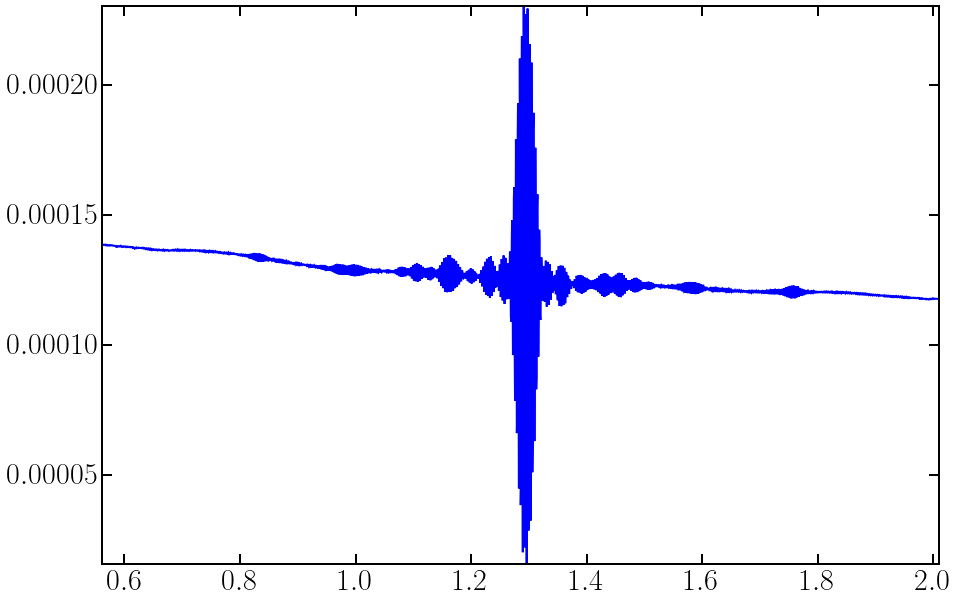

In [173]:
i = 3
fig, ax = plt.subplots(figsize=(15,10))
ax.plot(scans['sample']['encoder'][i], scans['sample']['signal'][i]);
ax.axis('tight');
plt.savefig(save_name + 'raw_interferogram.png')

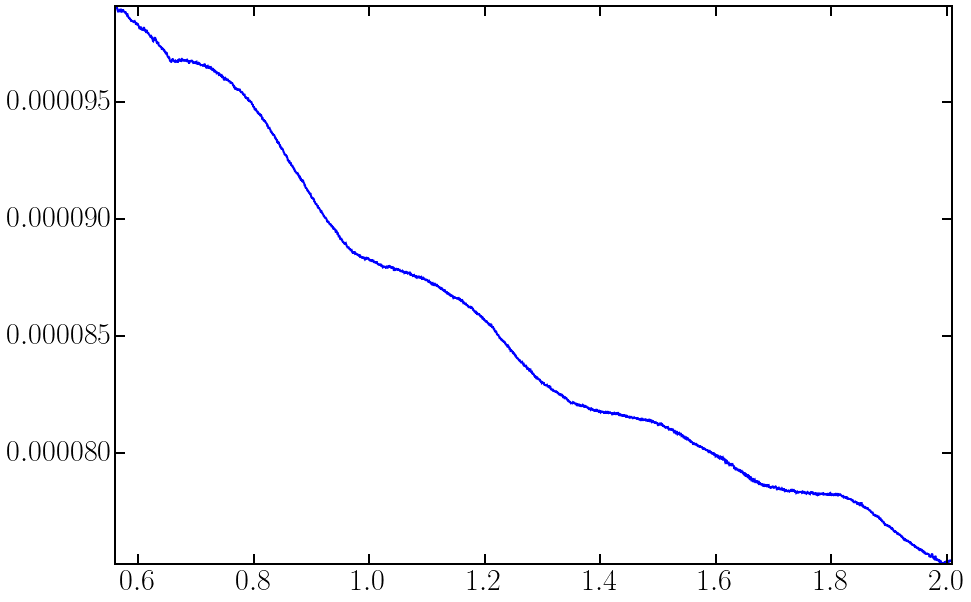

In [174]:
scans['no-sample']['one-arm']['signal-averaged'] = np.average(scans['no-sample']['one-arm']['signal'], axis=0)
scans['no-sample']['one-arm']['encoder-averaged'] = np.average(scans['no-sample']['one-arm']['encoder'], axis=0)

scans['sample']['one-arm']['signal-averaged'] = np.average(scans['sample']['one-arm']['signal'], axis=0)
scans['sample']['one-arm']['encoder-averaged'] = np.average(scans['sample']['one-arm']['encoder'], axis=0)

fig, ax = plt.subplots(figsize=(15,10))
ax.plot(scans['no-sample']['one-arm']['encoder-averaged'], scans['no-sample']['one-arm']['signal-averaged']);
ax.axis('tight');

In [175]:
N = scans['no-sample']['signal'].shape[0]
print(scans['no-sample']['signal'].shape[1])
signal_driftcorr = []
encoder_driftcorr = []
for i in range(N):
#     driftcorr = scans['no-sample']['signal'][i]
    driftcorr = (scans['no-sample']['signal'][i] - scans['no-sample']['one-arm']['signal-averaged'])
#     driftcorr /= np.sqrt(scans['one-arm']['signal-averaged'])
    driftcorr -= np.average(driftcorr)
#     peak = scans['no-sample']['encoder'][i][np.where(driftcorr == max(driftcorr))[0]][0]
#     thresh = np.logical_and(scans['no-sample']['encoder'][i] > (peak - 1.5), scans['no-sample']['encoder'][i] < (peak + 1.5))
#     Nmask = 400
#     mask = np.ones(Nmask)
#     avg = np.convolve(driftcorr, mask, 'same')/Nmask
#     driftcorr = driftcorr[thresh] - avg[thresh]
    signal_driftcorr += [driftcorr]
    encoder_driftcorr += [scans['no-sample']['encoder'][i]]
#     encoder_driftcorr += [scans['no-sample']['encoder'][i][thresh]]

scans['no-sample']['encoder-driftcorrected'] = np.array(encoder_driftcorr)
scans['no-sample']['signal-driftcorrected'] = np.array(signal_driftcorr)
scans['no-sample']['signal-averaged'] = np.average(signal_driftcorr, axis=0)

2801


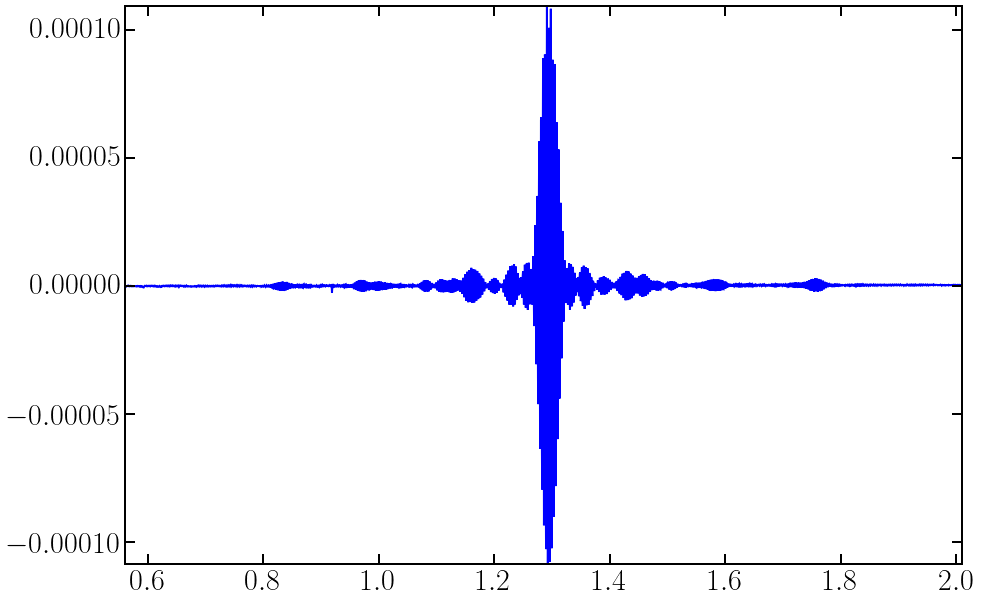

In [176]:
i = 5
fig, ax = plt.subplots(figsize=(15,10))
ax.plot(scans['no-sample']['encoder-driftcorrected'][i], scans['no-sample']['signal-driftcorrected'][i]);
ax.axis('tight');
mydata = [scans['no-sample']['encoder-driftcorrected'][i], scans['no-sample']['signal-driftcorrected'][i]]
np.savetxt('f.txt', mydata)
plt.savefig(save_name + 'driftcorrected_interferogram.png')

In [177]:
N = scans['sample']['signal'].shape[0]
signal_driftcorr = []
encoder_driftcorr = []
for i in range(N):
#     driftcorr = scans['sample']['signal'][i]
    driftcorr = (scans['sample']['signal'][i] - scans['sample']['one-arm']['signal-averaged'])
    driftcorr -= np.average(driftcorr)
#     peak = scans['sample']['encoder'][i][np.where(driftcorr == max(driftcorr))[0]][0]
#     thresh = np.logical_and(scans['sample']['encoder'][i] > (peak - 1.5), scans['sample']['encoder'][i] < (peak + 1.5))
#     Nmask = 400
#     mask = np.ones(Nmask)
#     avg = np.convolve(driftcorr, mask, 'same')/Nmask
#     driftcorr = driftcorr[thresh] - avg[thresh]
    signal_driftcorr += [driftcorr]
    encoder_driftcorr += [scans['sample']['encoder'][i]]
#     encoder_driftcorr += [scans['no-sample']['encoder'][i][thresh]]
    
scans['sample']['encoder-driftcorrected'] = np.array(encoder_driftcorr)
scans['sample']['signal-driftcorrected'] = np.array(signal_driftcorr)
scans['sample']['signal-averaged'] = np.average(signal_driftcorr, axis=0)

In [178]:
# Now lets try and correct for the phase
def quadratic(x, A, B, C):
    return A*x**2 + B*x + C

parameter = [  1.07511481e-04   3.44476158e+01  -4.45958147e+01   1.84925324e+03] 1.29459800349
parameter = [  1.07114940e-04   3.44181623e+01  -4.45568207e+01   1.84925008e+03] 1.29457291546
parameter = [  1.07410791e-04   3.44375512e+01  -4.45819877e+01   1.84924224e+03] 1.29457485022
parameter = [  1.07404711e-04   3.44405588e+01  -4.45863609e+01   1.84924408e+03] 1.2945887777
parameter = [  1.07317935e-04   3.44043063e+01  -4.45385519e+01   1.84923823e+03] 1.29456328664
parameter = [  1.07124108e-04   3.43588771e+01  -4.44802572e+01   1.84923308e+03] 1.29457831643


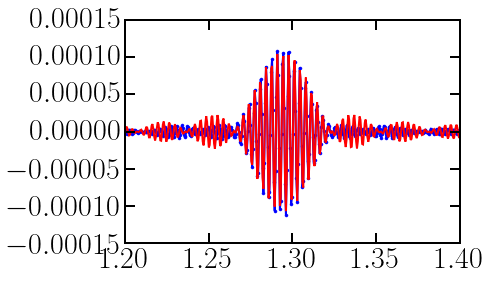

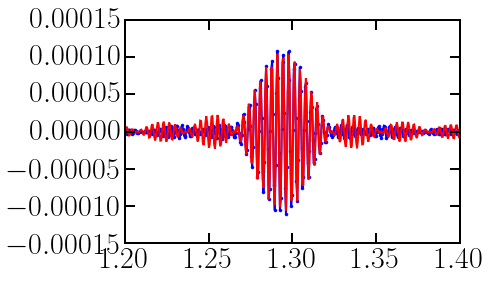

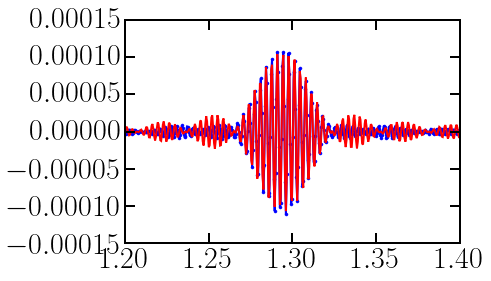

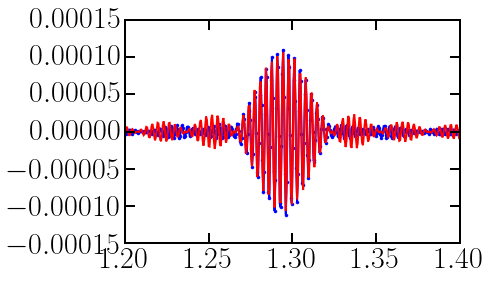

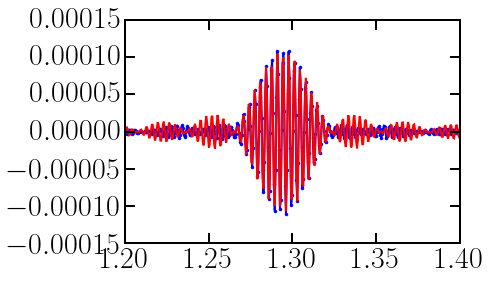

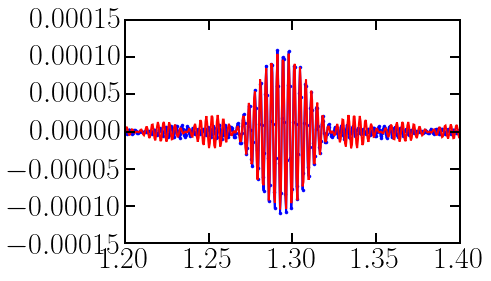

In [183]:
# First Find the right position of the origin of the interferogram
N = scans['no-sample']['signal-driftcorrected'].shape[0]
signal_peak = []
for i in range(N):
#    peak = np.where(scans['no-sample']['signal-driftcorrected'][i] ==\
#                    max(scans['no-sample']['signal-driftcorrected'][i]))[0][0]
#    y = scans['no-sample']['signal-driftcorrected'][i][peak-1: peak+2]
#    x = scans['no-sample']['encoder-driftcorrected'][i][peak-1:peak+2]
#    X = np.vstack([x**2, x, np.ones_like(x)]).T
#    A = np.linalg.solve(X, y)
#    actual_peak = -A[1]/(2*A[0])
#    sig_peak = quadratic(actual_peak, *list(A))
#    signal_peak += [sig_peak]
# data which you want to fit


    xdata = scans['no-sample']['encoder-driftcorrected'][i]
    ydata = scans['no-sample']['signal-driftcorrected'][i]
    mask=np.logical_and(xdata>=1.27,xdata<=1.33)
    xdata2=xdata[mask] #mask the unwanted data
    ydata2=ydata[mask]
# initial guess for the parameters
    parameter_initial = np.array([1.2e-4,40,-51.6,1850]) #A,B,C,D
# function to fit
    def func(x, A, B, C, D):
        return A*(np.sinc(B*x+C))*np.cos(D*x)
#fitting
    parameter_optimal, covariance = scipy.optimize.curve_fit(func, xdata2, ydata2, p0=parameter_initial)
    print("parameter =", parameter_optimal, -parameter_optimal[2]/parameter_optimal[1])
#
    y= func(xdata,*parameter_optimal)
#   y = func(xdata,parameter_optimal[0],parameter_optimal[1],parameter_optimal[2],parameter_optimal[3])
    plt.figure()
    plt.plot(xdata, ydata, 'b.-')
    plt.plot(xdata, y, 'r-')
    plt.xlim(1.2,1.4)
    plt.savefig("fitting_sinc.png")

#pltlabel = r'%d' %i
#ax.plot(x, y, '+', markersize=20)
#xs = np.r_[scans['no-sample']['encoder-driftcorrected'][i][peak-2]:scans['no-sample']['encoder-driftcorrected'][i][peak+2]:100j]
#ax.plot(xs, quadratic(xs, *list(A)), label=pltlabel)
#ax.legend(loc='best')
#ax.axis('tight')
#scans['no-sample']['encoder-driftcorrected'][i] -= actual_peak
#scans['no-sample']['encoder-driftcorrected'][i] *=2 # Encoder now represents the path length difference
#scans['no-sample']['signal-peak'] = signal_peak
#plt.savefig(save_name + 'no-sample_peakmatching.png')

for the scan 0 the position of zero p.d is 1.291150 and the peak value is 0.000109
for the scan 1 the position of zero p.d is 1.291159 and the peak value is 0.000109
for the scan 2 the position of zero p.d is 1.291164 and the peak value is 0.000109
for the scan 3 the position of zero p.d is 1.294530 and the peak value is 0.000111
for the scan 4 the position of zero p.d is 1.291180 and the peak value is 0.000109
for the scan 5 the position of zero p.d is 1.291174 and the peak value is 0.000109


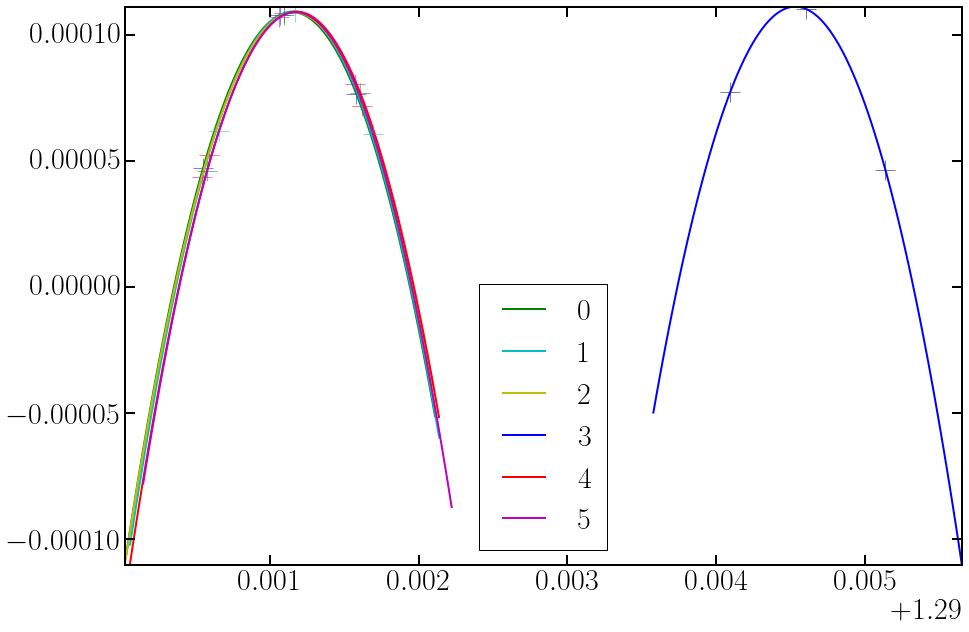

In [166]:
# First Find the right position of the origin of the interferogram
N = scans['no-sample']['signal-driftcorrected'].shape[0]
signal_peak = []
fig, ax =plt.subplots(figsize=(15,10))
for i in range(N):
    peak = np.where(scans['no-sample']['signal-driftcorrected'][i] ==\
                    max(scans['no-sample']['signal-driftcorrected'][i]))[0][0]
    y = scans['no-sample']['signal-driftcorrected'][i][peak-1: peak+2]
    x = scans['no-sample']['encoder-driftcorrected'][i][peak-1:peak+2]
    X = np.vstack([x**2, x, np.ones_like(x)]).T
    A = np.linalg.solve(X, y)
    actual_peak = -A[1]/(2*A[0])
    sig_peak = quadratic(actual_peak, *list(A))
    signal_peak += [sig_peak]
    pltlabel = r'%d' %i
    ax.plot(x, y, '+', markersize=20)
    xs = np.r_[scans['no-sample']['encoder-driftcorrected'][i][peak-2]:scans['no-sample']['encoder-driftcorrected'][i][peak+2]:100j]
    ax.plot(xs, quadratic(xs, *list(A)), label=pltlabel)
    ax.legend(loc='best')
    ax.axis('tight')
    scans['no-sample']['encoder-driftcorrected'][i] -= actual_peak
    scans['no-sample']['encoder-driftcorrected'][i] *=2 # Encoder now represents the path length difference
    print("for the scan %d the position of zero p.d is %1.6f and the peak value is %1.6f" %(i, actual_peak, sig_peak))
    


scans['no-sample']['signal-peak'] = signal_peak
plt.savefig(save_name + 'no-sample_peakmatching.png')

parameter = [  1.05452355e-04   3.44778738e+01  -4.46354118e+01   1.84925876e+03] 1.29461033602
parameter = [  1.05522695e-04   3.44615867e+01  -4.46142037e+01   1.84924766e+03] 1.29460677845
parameter = [  1.05322098e-04   3.44607237e+01  -4.46132843e+01   1.84925218e+03] 1.29461252065
parameter = [  1.05195405e-04   3.44074344e+01  -4.45444539e+01   1.84925169e+03] 1.2946171279
parameter = [  1.05553875e-04   3.44681973e+01  -4.46226960e+01   1.84924286e+03] 1.29460486808


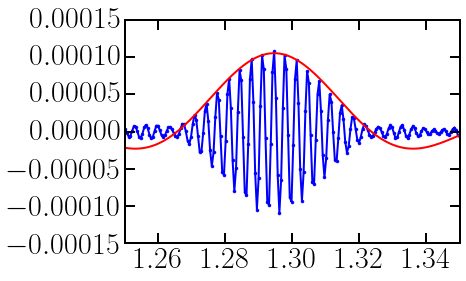

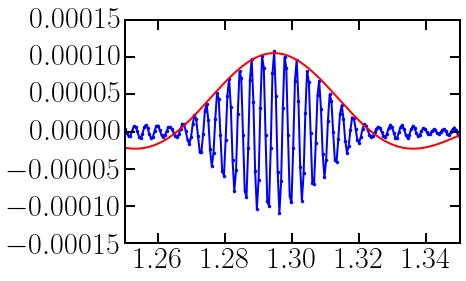

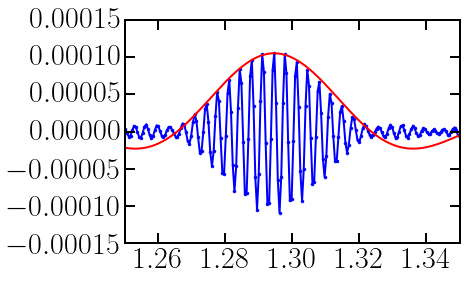

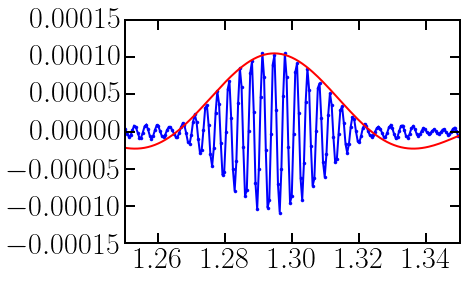

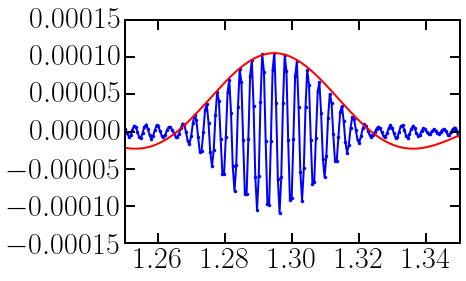

In [186]:
# First Find the right position of the origin of the interferogram
N = scans['sample']['signal-driftcorrected'].shape[0]
signal_peak = []
for i in range(N):
#    peak = np.where(scans['sample']['signal-driftcorrected'][i] ==\
#                    max(scans['sample']['signal-driftcorrected'][i]))[0][0]
#    y = scans['sample']['signal-driftcorrected'][i][peak-1: peak+2]
#    x = scans['sample']['encoder-driftcorrected'][i][peak-1:peak+2]
#    X = np.vstack([x**2, x, np.ones_like(x)]).T
#    A = np.linalg.solve(X, y)
#    actual_peak = -A[1]/(2*A[0])
#    sig_peak = quadratic(actual_peak, *list(A))
#    signal_peak += [sig_peak]
# data which you want to fit


    xdata = scans['sample']['encoder-driftcorrected'][i]
    ydata = scans['sample']['signal-driftcorrected'][i]
    mask=np.logical_and(xdata>=1.27,xdata<=1.33)
    xdata2=xdata[mask] #mask the unwanted data
    ydata2=ydata[mask]
# initial guess for the parameters
    parameter_initial = np.array([1.2e-4,40,-51.6,1850]) #A,B,C,D
# function to fit
    def func(x, A, B, C, D):
        return A*(np.sinc(B*x+C))*np.cos(D*x)
    def env(x,A,B,C):
        return A*np.sinc(B*x+C)
#fitting
    parameter_optimal, covariance = scipy.optimize.curve_fit(func, xdata2, ydata2, p0=parameter_initial)
    print("parameter =", parameter_optimal, -parameter_optimal[2]/parameter_optimal[1])
#
    y= func(xdata,*parameter_optimal)
#   y = func(xdata,parameter_optimal[0],parameter_optimal[1],parameter_optimal[2],parameter_optimal[3])
    y2= env(xdata,*parameter_optimal[:-1])
    plt.figure()
    plt.plot(xdata, ydata, 'b.-')
    plt.plot(xdata, y2, 'r-')
    plt.xlim(1.25,1.35)
    plt.savefig("fitting_sinc_sample.png")

#pltlabel = r'%d' %i
#ax.plot(x, y, '+', markersize=20)
#xs = np.r_[scans['sample']['encoder-driftcorrected'][i][peak-2]:scans['sample']['encoder-driftcorrected'][i][peak+2]:100j]
#ax.plot(xs, quadratic(xs, *list(A)), label=pltlabel)
#ax.legend(loc='best')
#ax.axis('tight')
#scans['sample']['encoder-driftcorrected'][i] -= actual_peak
#scans['sample']['encoder-driftcorrected'][i] *=2 # Encoder now represents the path length difference
#scans['sample']['signal-peak'] = signal_peak
#plt.savefig(save_name + 'sample_peakmatching.png')

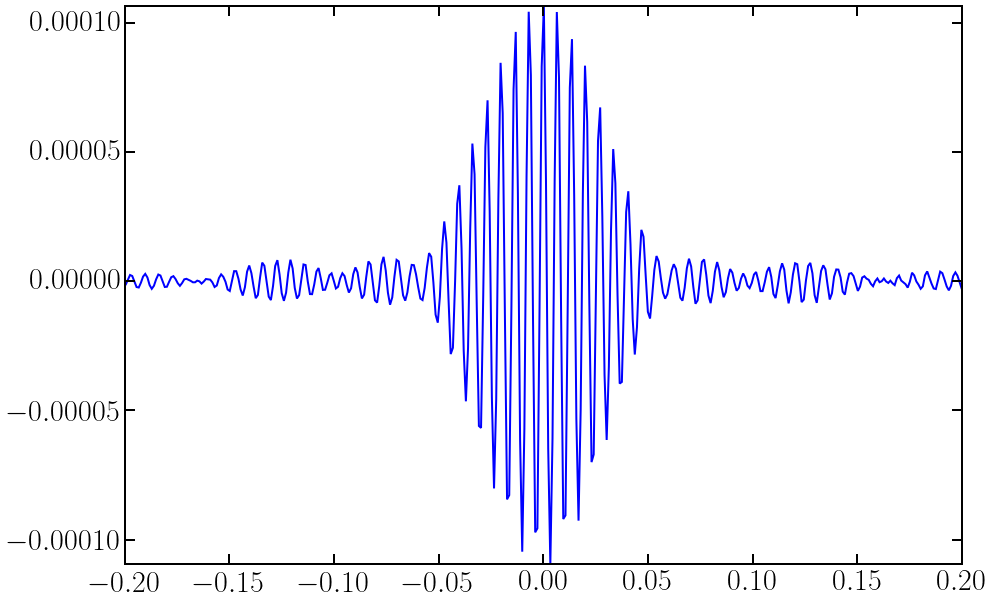

In [28]:
i = 2
fig, ax = plt.subplots(figsize=(15,10))
ax.plot(scans['sample']['encoder-driftcorrected'][i], scans['sample']['signal-driftcorrected'][i]);
ax.axis('tight');
ax.set_xlim(-0.2, 0.2)
plt.savefig(save_name + 'peakcorrected-interferogram.png')

In [13]:
# For each of the scans, we will be resampling the data to ensure that the points are evenly spaced.
# I will resample to an array of length 2**n such that the data point at 2**(n-1) is the one 
# of zero path difference. The array is circularly symmetric as best, meaning that x[n] == x[-n]. 
n = 15
k = 10.0
m = k*2**(1 - n)
# m = 2*k/(2**n - 1)
encoder_new = m*np.arange(0, 2**n + 1) - k
scans['encoder-resampled'] = encoder_new[:-1]
print len(scans['encoder-resampled'])

32768


In [14]:
N = scans['no-sample']['signal'].shape[0]
signal_new = []
signal_err = []
for i in xrange(N):
    f = interp1d(scans['no-sample']['encoder-driftcorrected'][i], scans['no-sample']['signal-driftcorrected'][i],\
                 kind='cubic', bounds_error=False, fill_value=0.0)
    signal_new += [f(scans['encoder-resampled'])]
    signal_err += [np.abs(signal_new[i][2**(n-1)] - scans['no-sample']['signal-peak'][i])]
    print "Finished working on the %d scan" %i
scans['no-sample']['signal-resampled'] = np.array(signal_new)
scans['no-sample']['signal-error'] = np.array(signal_err)

Finished working on the 0 scan
Finished working on the 1 scan
Finished working on the 2 scan
Finished working on the 3 scan
Finished working on the 4 scan
Finished working on the 5 scan


In [15]:
N = scans['sample']['signal'].shape[0]
signal_new = []
signal_err = []
for i in xrange(N):
    f = interp1d(scans['sample']['encoder-driftcorrected'][i], scans['sample']['signal-driftcorrected'][i],\
                 kind='cubic', bounds_error=False, fill_value=0.0)
    signal_new += [f(scans['encoder-resampled'])]
    signal_err += [np.abs(signal_new[i][2**(n-1)] - scans['no-sample']['signal-peak'][i])]
    print "Finished working on the %d scan" %i
scans['sample']['signal-resampled'] = np.array(signal_new)
scans['sample']['signal-error'] = np.array(signal_err)

Finished working on the 0 scan
Finished working on the 1 scan
Finished working on the 2 scan
Finished working on the 3 scan
Finished working on the 4 scan


In [16]:
1./scans['no-sample']['signal-error']

array([  5.19660522e+06,   4.45257800e+06,   1.80853035e+06,
         8.47962541e+06,   2.64251634e+06,   4.32935869e+09])

In [17]:
len(scans['no-sample']['signal-resampled'][0])
# scans['encoder-resampled'][1] - scans['encoder-resampled'][2]

32768

In [18]:
def get_odd(x):
    return 0.5*(x - np.roll(x[-1::-1], 1))

def get_even(x):
    return x - get_odd(x)

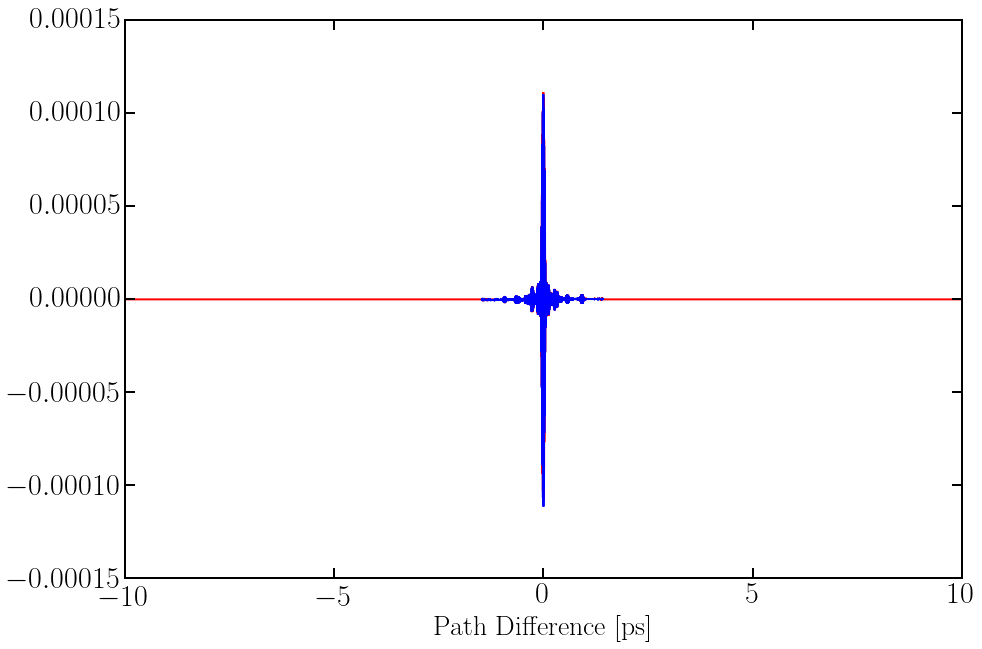

In [19]:
i = 3
fig, ax = plt.subplots(figsize=(15,10))
ax.plot(scans['encoder-resampled'], (scans['no-sample']['signal-resampled'][i]), 'r');
ax.plot(scans['no-sample']['encoder-driftcorrected'][i], (scans['no-sample']['signal-driftcorrected'][i]), 'b');
ax.set_xlabel('Path Difference [ps]')
plt.savefig(save_name + 'zeropadded-interferogram.png')

In [20]:
N = scans['no-sample']['signal'].shape[0]
dx = (scans['encoder-resampled'][1] - scans['encoder-resampled'][0])
ffts = []
scans['k'] = fftfreq(len(scans['no-sample']['signal-resampled'][0]), dx)
for i in xrange(N):
    y = fft((scans['no-sample']['signal-resampled'][i]))
    Ny = len(y)
    ffts += [y]
scans['no-sample']['signal-fft'] = np.array(ffts)

# ------ Use this part when you don't want to use the interpolated data ------------ #
# N = scans['no-sample']['signal'].shape[0]

# ffts = []
# k = [] 
# for i in xrange(N):
#     y = fft((scans['no-sample']['signal-driftcorrected'][i]))
#     dx = np.mean(np.diff(scans['no-sample']['encoder-driftcorrected'][i]))
#     Ny = len(y)
#     ffts += [y]
#     k += [fftfreq(Ny, dx)]
# scans['no-sample']['k'] = np.array(k)
# scans['no-sample']['signal-fft'] = np.array(ffts)

(138.0, 160.0, -0.0068044224288947505, 0.0068152045436472037)

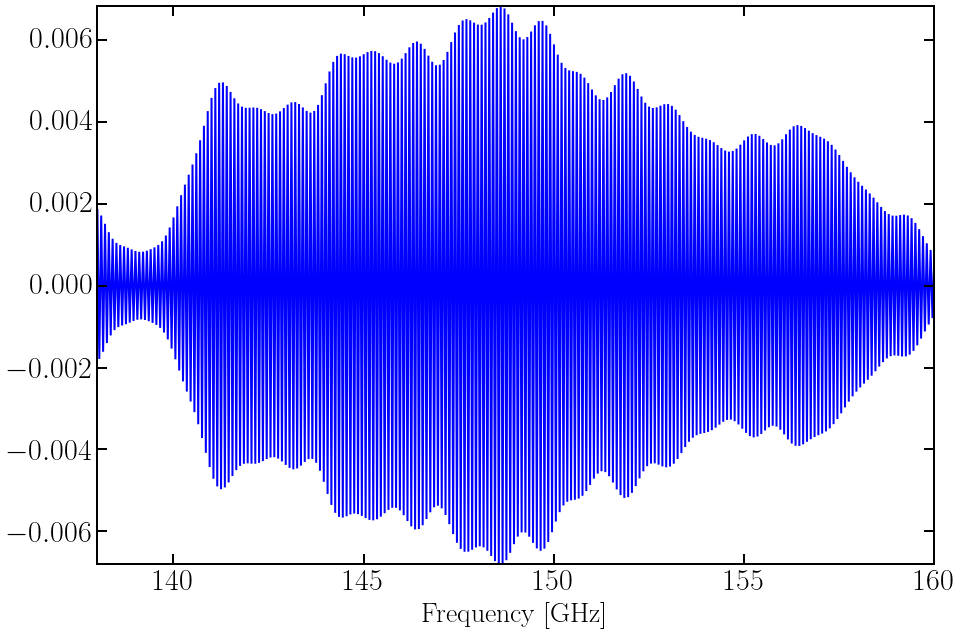

In [21]:
i = 3
fig, ax = plt.subplots(figsize=(15,10))
scans['thresh'] = np.logical_and(scans['k'] >= 138, scans['k'] <= 160)
ax.plot(scans['k'][scans['thresh']], np.real(scans['no-sample']['signal-fft'][i])[scans['thresh']]);
ax.set_xlabel('Frequency [GHz]')
ax.axis('tight');

# ------ Use this part when you don't want to use the interpolated data ------------ #
# scans['thresh'] = np.logical_and(scans['no-sample']['k'][i] >= 130, scans['no-sample']['k'][i] <= 170)

# ax.plot(scans['no-sample']['k'][i][scans['thresh']], np.abs(scans['no-sample']['signal-fft'][i])[scans['thresh']]);
# ax.axis('tight');

In [22]:
N = scans['sample']['signal'].shape[0]
dx = (scans['encoder-resampled'][1] - scans['encoder-resampled'][0])
ffts = []
for i in xrange(N):
    y = fft((scans['sample']['signal-resampled'][i]))
    Ny = len(y)
    ffts += [y]
scans['sample']['signal-fft'] = np.array(ffts)

# ------ Use this part when you don't want to use the interpolated data ------------ #
# N = scans['sample']['signal'].shape[0]

# ffts = []
# k = [] 
# for i in xrange(N):
#     y = fft((scans['sample']['signal-driftcorrected'][i]))
#     dx = np.mean(np.diff(scans['sample']['encoder-driftcorrected'][i]))
#     Ny = len(y)
#     ffts += [y]
#     k += [fftfreq(Ny, dx)]
# scans['sample']['k'] = np.array(k)
# scans['sample']['signal-fft'] = np.array(ffts)

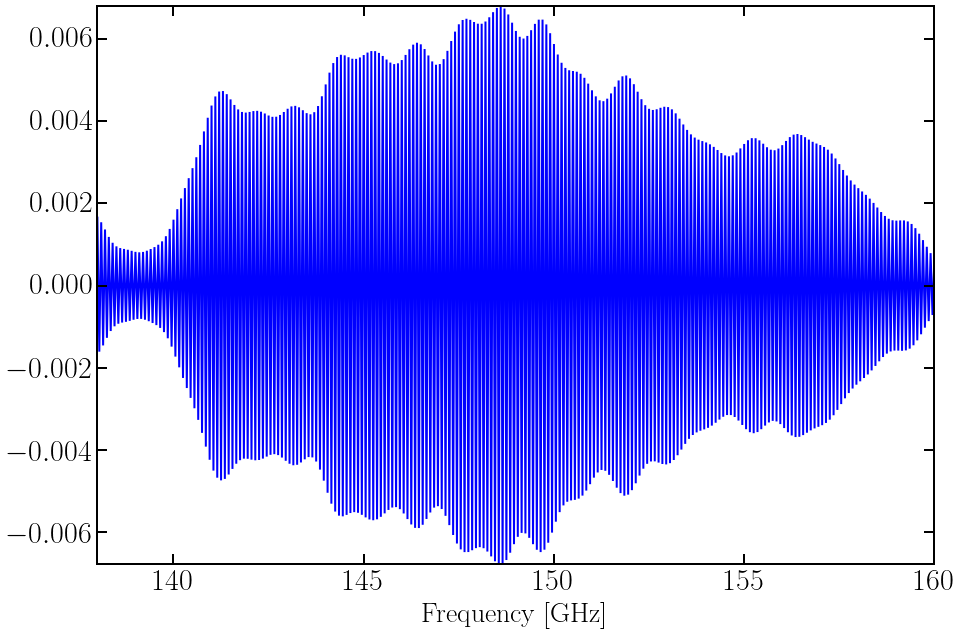

In [23]:
i = 0
fig, ax = plt.subplots(figsize=(15,10))
# scans['thresh'] = np.logical_and(scans['k'] >= 130, scans['k'] <= 170)
ax.plot(scans['k'][scans['thresh']], np.real(scans['no-sample']['signal-fft'][i])[scans['thresh']]);
ax.axis('tight');
ax.set_xlabel('Frequency [GHz]')

# ------ Use this part when you don't want to use the interpolated data ------------ #
# scans['thresh'] = np.logical_and(scans['sample']['k'][i] >= 130, scans['sample']['k'][i] <= 170)

# ax.plot(scans['sample']['k'][i][scans['thresh']], np.abs(scans['sample']['signal-fft'][i])[scans['thresh']]);
# ax.axis('tight');

In [24]:
scans['no-sample']['fft-averaged'] = np.mean(np.real(scans['no-sample']['signal-fft']), axis=0)
scans['no-sample']['fft-error'] = np.std(np.real(scans['no-sample']['signal-fft']), axis=0)
scans['sample']['fft-averaged'] = np.mean(np.real(scans['sample']['signal-fft']), axis=0)
scans['sample']['fft-error'] = np.std(np.real(scans['sample']['signal-fft']), axis=0)

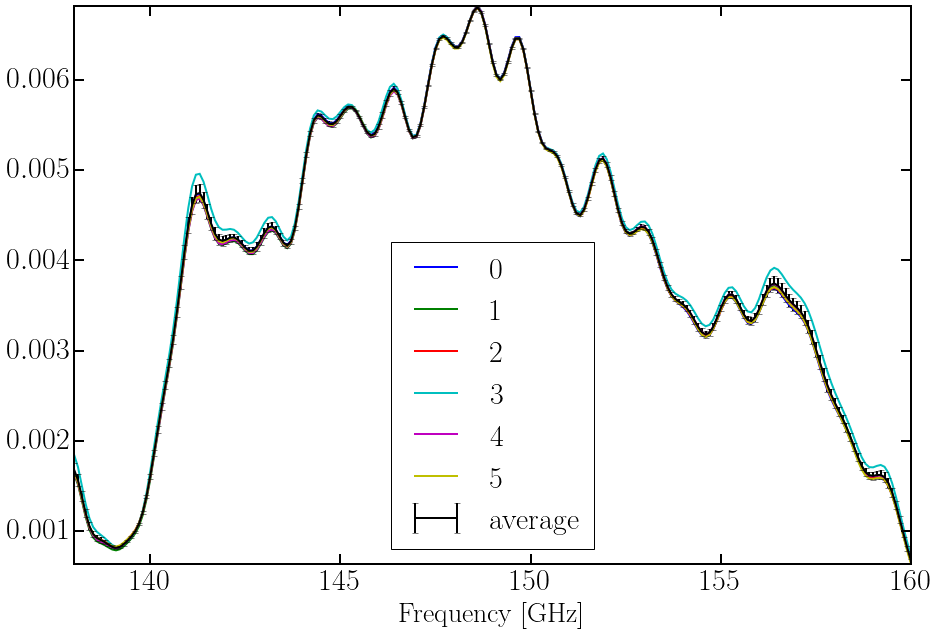

In [25]:
fig, ax = plt.subplots(figsize=(15,10))
N = scans['no-sample']['signal'].shape[0]
for i in xrange(N):
    pltlabel = r'%d' %i
    ax.plot(scans['k'][scans['thresh']][::2],\
            np.real(scans['no-sample']['signal-fft'][i])[scans['thresh']][::2], label=pltlabel)
ax.errorbar(scans['k'][scans['thresh']][::2],\
            (scans['no-sample']['fft-averaged'])[scans['thresh']][::2],\
            yerr = (scans['no-sample']['fft-error'])[scans['thresh']][::2], label="average",\
           fmt='-', ecolor='k', color='k')
ax.legend(loc='best');
ax.axis('tight');
ax.set_xlabel('Frequency [GHz]')
plt.savefig(save_name + 'no-sample_fft.png')

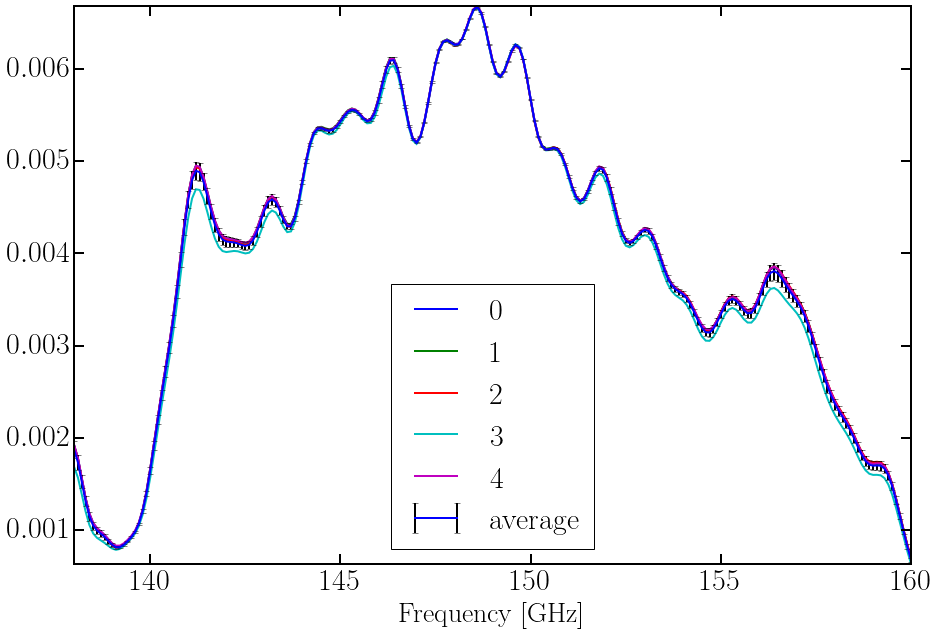

In [26]:
fig, ax = plt.subplots(figsize=(15,10))
N = scans['sample']['signal'].shape[0]
for i in xrange(N):
    pltlabel = r'%d' %i
    ax.plot(scans['k'][scans['thresh']][::2], np.real(scans['sample']['signal-fft'][i])[scans['thresh']][::2], label=pltlabel)
ax.errorbar(scans['k'][scans['thresh']][::2], (scans['sample']['fft-averaged'])[scans['thresh']][::2],\
            yerr = (scans['sample']['fft-error'])[scans['thresh']][::2], label="average",\
           fmt='-', ecolor='k', color='blue')
ax.legend(loc='best');
ax.axis('tight');
ax.set_xlabel('Frequency [GHz]')
plt.savefig(save_name + 'sample_fft.png')

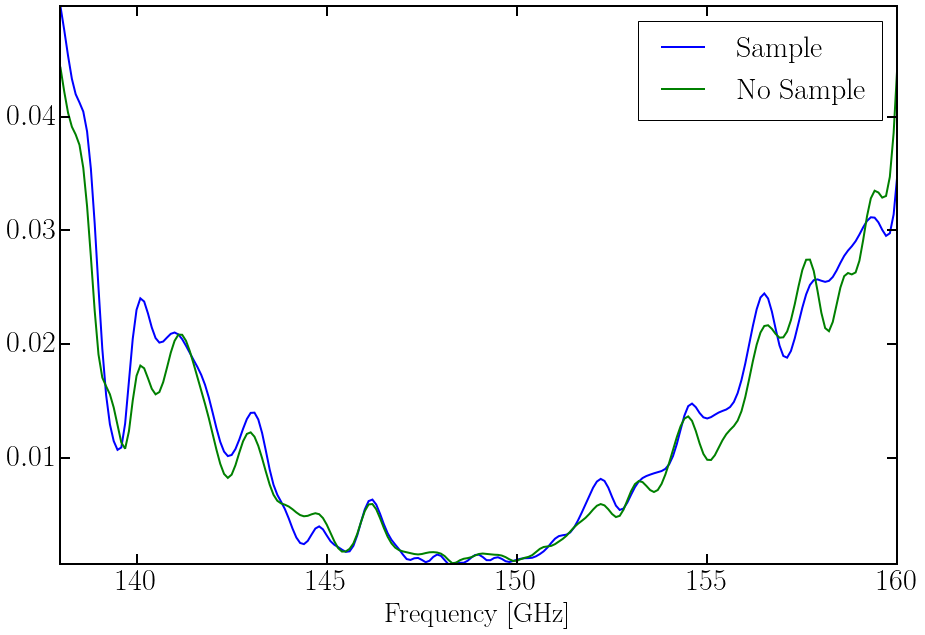

In [27]:
scans['sample']['relative-error'] = np.real(scans['sample']['fft-error'])/np.real(scans['sample']['fft-averaged'])
scans['no-sample']['relative-error'] = np.real(scans['no-sample']['fft-error'])/np.real(scans['no-sample']['fft-averaged'])
fig, ax = plt.subplots(figsize=(15,10))

ax.plot(scans['k'][scans['thresh']][::2], scans['sample']['relative-error'][scans['thresh']][::2], label='Sample')
ax.plot(scans['k'][scans['thresh']][::2], scans['no-sample']['relative-error'][scans['thresh']][::2], label='No Sample')
ax.legend(loc='best');
ax.axis('tight');
ax.set_xlabel('Frequency [GHz]')
plt.savefig(save_name + 'relative_error.png')

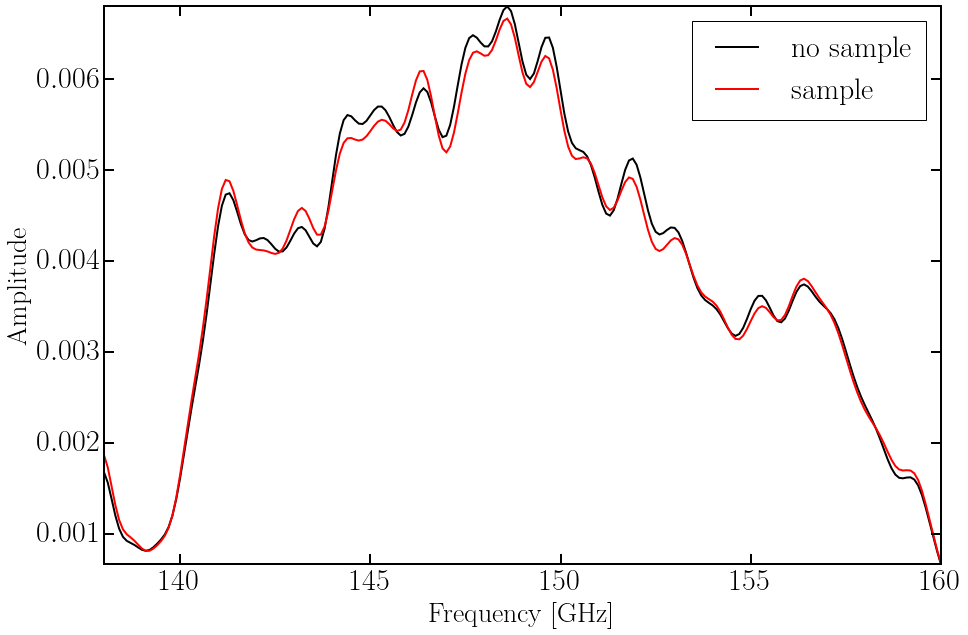

In [29]:
i = 2
fig, ax = plt.subplots(figsize=(15,10))
ax.plot(scans['k'][scans['thresh']][::2], np.real(scans['no-sample']['fft-averaged'][scans['thresh']][::2]), 'k', label='no sample')
ax.plot(scans['k'][scans['thresh']][::2], np.real(scans['sample']['fft-averaged'][scans['thresh']][::2]), 'r', label='sample');
ax.set_xlabel('Frequency [GHz]')
ax.set_ylabel('Amplitude');
ax.legend(loc='best');
ax.axis('tight');
ax.set_xlabel('Frequency [GHz]')
plt.savefig(save_name + 'no-sample_vs_sample_fft.png')

In [30]:
scans['ratio'] = np.real(scans['sample']['fft-averaged'])/np.real(scans['no-sample']['fft-averaged'])
scans['ratio-error'] = scans['ratio']*\
np.sqrt((scans['sample']['relative-error'])**2 + \
        (scans['no-sample']['relative-error'])**2 )

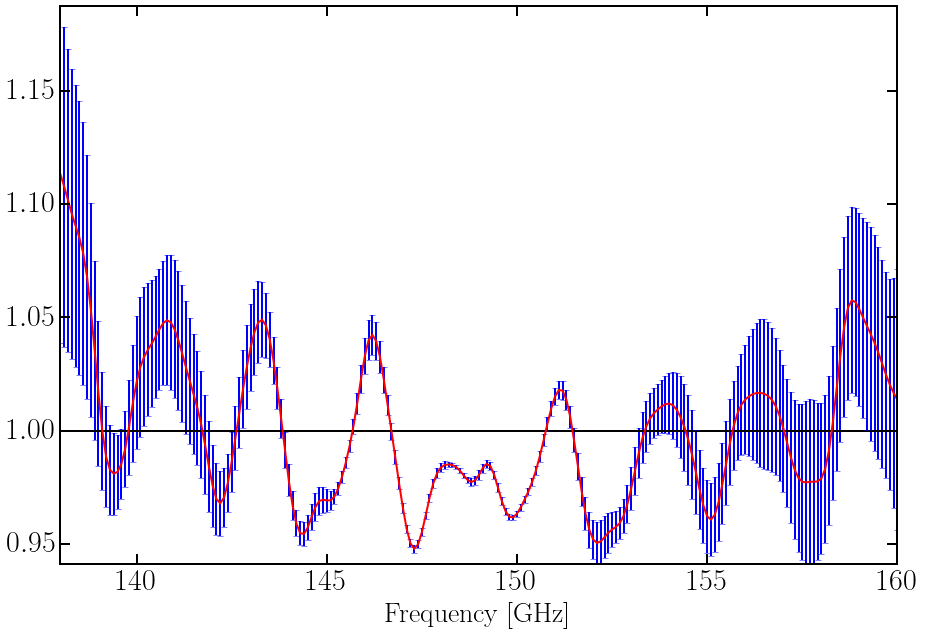

In [31]:
fig, ax = plt.subplots(figsize=(15,10))
ax.errorbar(scans['k'][scans['thresh']][::2], scans['ratio'][scans['thresh']][::2],\
            yerr=scans['ratio-error'][scans['thresh']][::2], fmt='r-', ecolor='b');
kmin = scans['k'][scans['thresh']][0]
kmax = scans['k'][scans['thresh']][-1]
# ax.plot(scans['k'][scans['thresh']], scans['ratio'][scans['thresh']]);
ax.hlines(1.0, kmin, kmax, colors='k', linestyles='solid');
ax.axis('tight');
ax.set_xlabel('Frequency [GHz]')
plt.savefig(save_name + 'fringes_with_ebars.png')

In [ ]:
def transmissionModel(nu, R, T, L, phi):
    A = (T/(1-R))**2
    F = 4*R/(1-R)**2
    B = 2*np.pi*L/c
    return A*1./(1 + F * np.sin(B*nu + phi)**2)

def jacknifeError(x, x_avg, N):
    return (np.sum((x - x_avg)**2)*(N-1)/N)**0.5

R = 0.004
# F = 4*R/(1-R)**2
B = 2*2*np.pi*scans['L']/c
phi = 1*np.pi
# A = 1.0
T = 0.99
# guesses = [R, T, B, phi]
guesses = [0.04, 0.958, scans['L'], 1.5*phi]

print guesses

In [ ]:
scans['fit-thresh'] = np.logical_and(scans['k'] >= 145, scans['k'] <= 160)

In [ ]:
popt, pcov = curve_fit(transmissionModel, scans['k'][scans['fit-thresh']],\
                           scans['ratio'][scans['fit-thresh']], p0=guesses,\
                           sigma=scans['ratio-error'][scans['fit-thresh']],\
                      bounds=([0, 0, 0.0*scans['L'], 0.0],[1, 1, 2.0*scans['L'], 2*np.pi]))

print popt

In [ ]:
fig, ax = plt.subplots(figsize=(15,10))

ax.errorbar(scans['k'][scans['thresh']][::2], scans['ratio'][scans['thresh']][::2],\
            yerr=scans['ratio-error'][scans['thresh']][::2], fmt='b.-', ecolor='b');

ax.plot(scans['k'][scans['thresh']], transmissionModel(scans['k'][scans['thresh']], *guesses), 'r-');
ax.axis('tight');
ax.grid(which='major')
ax.set_xlabel('Frequency [GHz]')
plt.savefig(save_name + 'curve-fit_fringes_with_ebars.png')

In [ ]:
#Let's see if using the likelihood function will be more useful
def lnlike(theta, x, y, yerr):
    model = transmissionModel(x, *theta)
    inv_sigma2 = 1.0/(yerr**2)
    return -0.5*(np.sum((y-model)**2*inv_sigma2))

nll = lambda *args: -lnlike(*args)
result = op.minimize(nll, guesses, args=(scans['k'][scans['fit-thresh']], scans['ratio'][scans['fit-thresh']],\
                                         scans['ratio-error'][scans['fit-thresh']]),\
                     bounds=[(0,1.0), (0,1.0),(0.0*scans['L'],5.0*scans['L']),(None, None)])
R_ml, T_ml, L_ml, phi_ml = result["x"]
print result['x']
print result['message']
chisq =  lnlike(result['x'],scans['k'][scans['fit-thresh']],\
             scans['ratio'][scans['fit-thresh']],scans['ratio-error'][scans['fit-thresh']] )
print chisq
scans['chisq'] = chisq

In [ ]:
fig, ax = plt.subplots(figsize=(15,10))

ax.errorbar(scans['k'][scans['thresh']][::2], scans['ratio'][scans['thresh']][::2],\
            yerr=scans['ratio-error'][scans['thresh']][::2], fmt='b.-', ecolor='b');

ax.plot(scans['k'][scans['thresh']], transmissionModel(scans['k'][scans['thresh']], *result["x"]), 'r-');
ax.grid(which='major')
ax.axis('tight')
ax.set_xlabel('Frequency [GHz]')
plt.savefig(save_name + 'minimize_fringes_with_ebars.png')

In [ ]:
# R_ml = 1 + 2./F_ml*(1 - np.sqrt(1 + F_ml))
# T_ml = np.sqrt(A_ml)*(1-R)
# As_ml = 1 - (R_ml + T_ml)
# deff_ml = B_ml*c/(2*np.pi)
# phi_ml = (phi_ml)/np.pi

In [ ]:
def lnprior(theta):
    R, T, L, phi = theta
    if 0.0 < R < 1.0 and 0.0 < T < 1.0 and 0.5*scans['L'] < L < 2.0*scans['L'] and -10*np.pi < phi < 10*np.pi :
        return 0.0
    else:
        return - np.inf
def lnprob(theta, x, y, yerr):
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(theta, x, y, yerr)

In [ ]:
ndim, nwalkers = 4, 1000
pos = [result["x"] + 1e-4*np.random.randn(ndim) for i in range(nwalkers)]
# pos = [popt + 1e-4*np.random.randn(ndim) for i in range(nwalkers)]

In [ ]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(scans['k'][scans['fit-thresh']], scans['ratio'][scans['fit-thresh']],\
                                         scans['ratio-error'][scans['fit-thresh']]))

In [ ]:
sampler.run_mcmc(pos, 1000);

In [ ]:
samples = sampler.chain[:, 50:, :].reshape((-1, ndim))

In [ ]:
figure, ax = plt.subplots(nrows = ndim, ncols=ndim, figsize=(15,10))
# 
fig = corner.corner(samples, title_fmt='.4f',labels=["$R$", "$T$", "$L$", "$\phi$"],\
                      truths=result["x"], fig=figure,show_titles=True, use_math_text=True)
fig.savefig(save_name + 'corner_plot.png')

In [ ]:
fig,ax = plt.subplots(figsize=(15,10))
for R,T,L, phi in samples[np.random.randint(len(samples), size=200)]:
    ax.plot(scans['k'][scans['thresh']],\
            transmissionModel(scans['k'][scans['thresh']],R,T,B,phi), color="k", alpha=0.1)
# ax.plot(scans['k'][scans['thresh']], transmissionModel(scans['k'][scans['thresh']],*guesses), color="r", alpha=0.8)
ax.errorbar(scans['k'][scans['thresh']][::4], scans['ratio'][scans['thresh']][::4],\
            yerr=scans['ratio-error'][scans['thresh']][::4], fmt="r.-",ecolor='b')
ax.axis('tight');
ax.set_xlabel('Frequency [GHz]')
plt.savefig(save_name + 'projected-space.png')

In [ ]:
samples[:, 2] = np.exp(samples[:, 2])
R_mcmc, T_mcmc, L_mcmc, phi_mcmc = map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]),
                             zip(*np.percentile(samples, [16, 50, 84],
                                                axis=0)))
A_mcmc = (1-(R_mcmc[0] + T_mcmc[0]), ((R_mcmc[1]**2 + T_mcmc[1]**2))**0.5, (R_mcmc[2]**2 + T_mcmc[2]**2)**0.5)
scans['R_mcmc'] = R_mcmc
scans['T_mcmc'] = T_mcmc
scans['A_mcmc'] = A_mcmc
scans['L_mcmc'] = L_mcmc
scans['phi_mcmc'] = phi_mcmc

In [ ]:
datafile = h5py.File('mesh_filters.hdf5','a')
base_name = hdf5_name.split('/')[0]
try:
    curr_grp = datafile[hdf5_name]
except KeyError:
    curr_grp = datafile.create_group(hdf5_name)
curr_grp = scans

In [ ]:
1 - curr_grp['R_mcmc'][0]-curr_grp['T_mcmc'][0]

In [ ]:
curr_grp['A_mcmc']

In [ ]:
curr_grp['T_mcmc']

In [ ]:
curr_grp['R_mcmc']

In [ ]:
hdf5_name

In [ ]:
'a' in ['a', 'b', 'c']

In [32]:
np.sinc?

In [ ]:
fig, ax = plt.subplots(figsize=(15,10))
ax.plot(samples[:,1])

In [ ]:
datafile[hdf5_name]

In [ ]:
# # data_label = "15-1"
# N = len(scans['k'][scans['thresh']])
# A_vec = np.zeros(N)
# F_vec = np.zeros(N)
# B_vec = np.zeros(N)
# phi_vec = np.zeros(N)
# indices = np.arange(N)

# for i in xrange(N):
#     points = (indices != i)
#     popt, pcov = curve_fit(transmissionModel, scans['k'][scans['fit-thresh']][points],\
#                            scans['ratio'][scans['fit-thresh']][points], p0=guesses,\
#                            sigma=scans['ratio-error'][scans['fit-thresh']][points]\
#                                   ,bounds=([0, 0, 0, -np.pi],[2.0,np.inf,20,np.pi]))
#     perr = np.sqrt(np.diag(pcov))
#     A_vec[i], F_vec[i], B_vec[i], phi_vec[i] = popt#[0], popt[1], popt[2], popt[3], popt[4] 

# # Now we want to extract histograms of the 4 parameters but in terms of things relevant to
# # the actual FP form of interest
# R = 1 + 2./F_vec*(1 - np.sqrt(1 + F_vec))
# T = np.sqrt(A_vec)*(1-R)
# As = 1 - (R + T)
# d_eff = B_vec*c/(4*np.pi)
# phi = phi_vec/np.pi

# R_avg = np.average(R)
# R_err = jacknifeError(R, R_avg, N)

# T_avg = np.average(T)
# T_err = jacknifeError(T, T_avg, N)

# As_avg = np.average(As)
# As_err = jacknifeError(As, As_avg, N)

# deff_avg = np.average(d_eff)
# deff_err = jacknifeError(d_eff, deff_avg, N)

# phi_avg = np.average(phi)
# phi_err = jacknifeError(phi, phi_avg, N)
# print "The estimated value of R is %1.6f +/- %1.6f" %(R_avg, R_err)
# print "The estimated value of T is %1.6f +/- %1.6f" %(T_avg, T_err)
# print "The estimated value of A is %1.6f +/- %1.6f" %(As_avg, As_err)
# print "The estimated value of d_eff is %1.6f +/- %1.6f" %(deff_avg, deff_err)
# print "The estimated value of phi is %1.6f +/- %1.6f" %(phi_avg, phi_err)

# fig, ax = plt.subplots(figsize=(15,10))
# n, bins, patches = ax.hist(R, bins=50, normed=True, histtype='step',\
#                            log=False, linewidth=2.0, label='R estimates')
# bincenters = 0.5*(bins[1:] + bins[:-1])
# pdf = mlab.normpdf(bincenters, R_avg, R_err)
# # ax.plot(bincenters, pdf, 'r--', linewidth=2.0, label='gaussian profile')
# ax.legend(loc='best')
# ax.set_xticklabels(["{:1.5g}".format(t) for t in ax.get_xticks()])
# ax.set_xlabel(r'R', fontsize=32);

# fig, ax = plt.subplots(figsize=(15,10))
# n, bins, patches = ax.hist(T, bins=50, normed=True, histtype='step',\
#                            log=False, linewidth=2.0, label='T estimates')
# bincenters = 0.5*(bins[1:] + bins[:-1])
# pdf = mlab.normpdf(bincenters, T_avg, T_err)
# # ax.plot(bincenters, pdf, 'r--', linewidth=2.0, label='gaussian profile')
# ax.legend(loc='upper left')
# ax.set_xticklabels(["{:1.5g}".format(t) for t in ax.get_xticks()])
# ax.set_xlabel(r'T', fontsize=32);

# fig, ax = plt.subplots(figsize=(15,10))
# n, bins, patches = ax.hist(As, bins=50, normed=True, histtype='step',\
#                            log=False, linewidth=2.0, label='As estimates')
# bincenters = 0.5*(bins[1:] + bins[:-1])
# pdf = mlab.normpdf(bincenters, As_avg, As_err)
# # ax.plot(bincenters, pdf, 'r--', linewidth=2.0, label='gaussian profile')
# ax.legend(loc='upper left')
# ax.set_xticklabels(["{:1.5g}".format(t) for t in ax.get_xticks()])
# ax.set_xlabel(r'As', fontsize=32);

# fig, ax = plt.subplots(figsize=(15,10))
# n, bins, patches = ax.hist(d_eff, bins=50, normed=True, histtype='step',\
#                            log=False, linewidth=2.0, label=r'd eff estimates')
# bincenters = 0.5*(bins[1:] + bins[:-1])
# pdf = mlab.normpdf(bincenters, deff_avg, deff_err)
# # ax.plot(bincenters, pdf, 'r--', linewidth=2.0, label='gaussian profile')
# ax.legend(loc='upper left')
# ax.set_xticklabels(["{:1.5g}".format(t) for t in ax.get_xticks()])
# ax.set_xlabel(r'Effective distance [mm]', fontsize=32);

# fig, ax = plt.subplots(figsize=(15,10))
# n, bins, patches = ax.hist(phi, bins=50, normed=True, histtype='step',\
#                            log=False, linewidth=2.0, label=r'$\phi$ estimates')
# bincenters = 0.5*(bins[1:] + bins[:-1])
# pdf = mlab.normpdf(bincenters, phi_avg, phi_err)
# # ax.plot(bincenters, pdf, 'r--', linewidth=2.0, label='gaussian profile')
# ax.legend(loc='upper left')
# ax.set_xticklabels(["{:1.5g}".format(t) for t in ax.get_xticks()])
# ax.set_xlabel(r'$\phi/\pi$', fontsize=32);

# params = [(T_avg/(1-R_avg))**2, 4*R_avg/(1-R_avg)**2, 4*np.pi*deff_avg/c, phi_avg*np.pi]
# fig, ax = plt.subplots(figsize=(15,10))

# ax.errorbar(scans['k'][scans['thresh']][::4], scans['ratio'][scans['thresh']][::4],\
#             yerr=scans['ratio-error'][scans['thresh']][::4], fmt='b.', ecolor='b');

# ax.plot(scans['k'][scans['thresh']], transmissionModel(scans['k'][scans['thresh']], *params), 'r-');